In [13]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time
import random
from sklearn.neighbors import KNeighborsClassifier

filepath = "./dataset/"

ford_train = []
volks_train = []

In [14]:
def HOG_features(img, nbins = 8, block_size = (4,4), cell_size = (4, 4)):
    h, w, _ = img.shape
    cell_h, cell_w = cell_size
    bl_h, bl_w = block_size
    
    hog = cv2.HOGDescriptor(_winSize=(w // cell_w * cell_w, 
                                        h // cell_h * cell_h),
                            _blockSize=(bl_w * cell_w, bl_h * cell_h),
                            _blockStride=(cell_w, cell_h),
                            _cellSize = (cell_w, cell_h),
                            _nbins = nbins)
    
    n_cells = (h // cell_h, h // cell_w)
    
    # Compute HoG features
    hog_feats = hog.compute(img)\
            .reshape(n_cells[1] - bl_w + 1,
                    n_cells[0] - bl_h + 1,
                    bl_h, bl_w, nbins) \
            .transpose((1, 0, 2, 3, 4)) 
    
    # computation for BlockNorm
    gradients = np.full((n_cells[0], n_cells[1], nbins), 0, dtype=float)
    cell_count = np.full((n_cells[0], n_cells[1], 1), 0, dtype=int)
    
    for off_y in range(block_size[0]):
        for off_x in range(block_size[1]):
            gradients[off_y:n_cells[0] - bl_h + off_y + 1,
                        off_x:n_cells[1] - bl_w + off_x + 1] += \
                hog_feats[:, :, off_y, off_x, :]
            cell_count[off_y:n_cells[0] - bl_h + off_y + 1,
                        off_x:n_cells[1] - bl_w + off_x + 1] += 1
            
    gradients /= cell_count
    return gradients

In [15]:
# 1. Resize test and training images to 128 x 128
resize = 128
for i in range(1, 6):
    try:
        ford_train.append(cv2.resize(cv2.imread(filepath + "ford_train%d.jpeg" % i), (resize,resize)))
    except:
        ford_train.append(cv2.resize(cv2.imread(filepath + "ford_train%d.png" % i), (resize,resize)))
    
    try:
        volks_train.append(cv2.resize(cv2.imread(filepath + "volks_train%d.jpeg" % i), (resize,resize)))
    except:
        volks_train.append(cv2.resize(cv2.imread(filepath + "volks_train%d.png" % i), (resize,resize)))

In [16]:
# 2. Compute HoG features of size (32,32,8). Apply blocknorm in 4 x 4 cell

# Cell size = (128 // 4, 128 // 4)
ford_feat = []
vw_feat = []
for i in ford_train:
    ford_feat.append(HOG_features(i))
for i in volks_train:
    vw_feat.append(HOG_features(i))

In [17]:
# 3. Fit a nearest neighbours classifier with k = 3

#Create input and output arrays to perform k-NN classifier
train_op = ["Ford" for _ in range(len(ford_train))] + ["Volkswagen" for _ in range(len(volks_train))]
train_x = np.array(ford_feat + vw_feat)
train_x = train_x.reshape(train_x.shape[0], -1)

neigh = KNeighborsClassifier(n_neighbors = 3)
neigh.fit(train_x, train_op)

KNeighborsClassifier(n_neighbors=3)

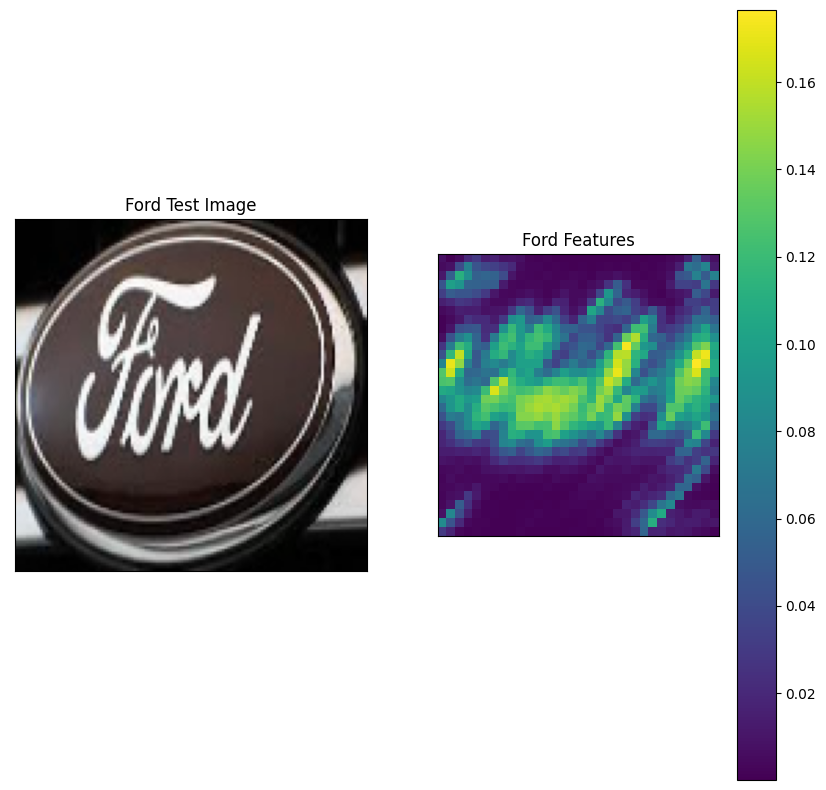

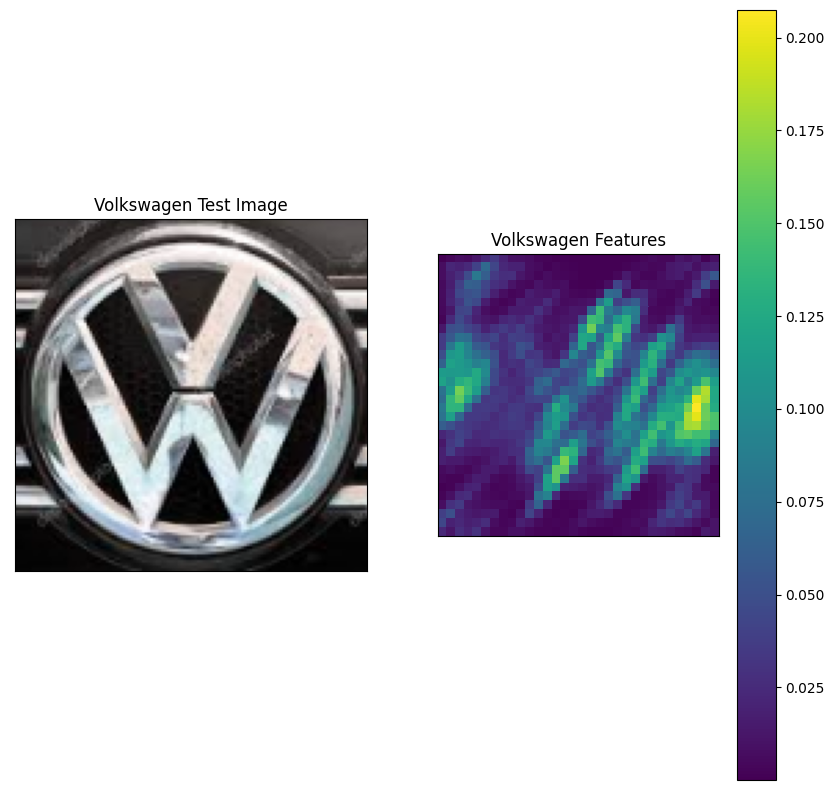

In [18]:
# 4. Computer HoG features and display features for both images

ford_test = cv2.resize(cv2.imread(filepath + "ford_test.jpeg"), (resize,resize))
volks_test = cv2.resize(cv2.imread(filepath + "volks_test.jpeg"), (resize,resize))
# Cell size = (128 // 4, 128 // 4)
ford_feat_t = HOG_features(ford_test)
vw_feat_t = HOG_features(volks_test)

# Display original ford image with its HoG features
plt.figure(figsize = (10,10))
plt.subplot(121)
plt.imshow(ford_test, cmap='gray')
plt.title("Ford Test Image"), plt.xticks([]), plt.yticks([])

gradients = ford_feat_t
bin = 0  # angle is 360 / nbins * direction
plt.subplot(122)
plt.pcolor(gradients[:, :, bin])
plt.gca().invert_yaxis()
plt.gca().set_aspect('equal', adjustable='box')
plt.title("Ford Features"), plt.xticks([]), plt.yticks([])
plt.colorbar()
plt.show()

# Display original volkswagen image with its HoG features
plt.figure(figsize = (10,10))
plt.subplot(121)
plt.imshow(volks_test, cmap='gray')
plt.title("Volkswagen Test Image"), plt.xticks([]), plt.yticks([])

gradients = vw_feat_t
bin = 0  # angle is 360 / nbins * direction
plt.subplot(122)
plt.pcolor(gradients[:, :, bin])
plt.gca().invert_yaxis()
plt.gca().set_aspect('equal', adjustable='box')
plt.title("Volkswagen Features"), plt.xticks([]), plt.yticks([])
plt.colorbar()
plt.show()

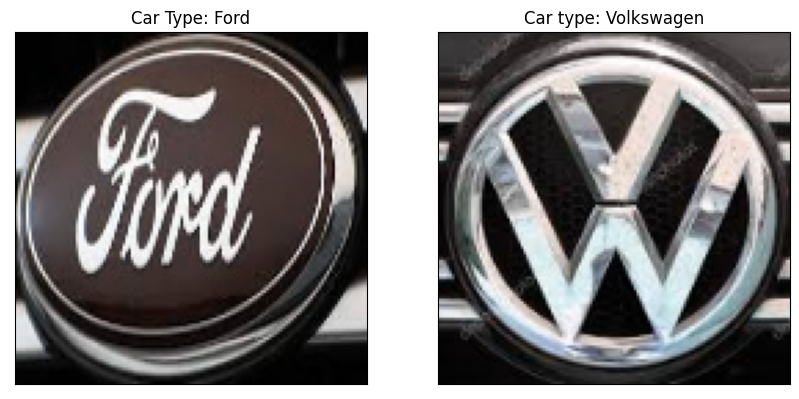

In [22]:
# 5. Predict output for test set
test_x = np.array([ford_feat_t] + [vw_feat_t])
test_x = test_x.reshape(test_x.shape[0], -1)

test_y = neigh.predict(test_x)

# Display each test image with its predicted class
plt.figure(figsize = (10,10))
plt.subplot(121)
plt.imshow(ford_test, cmap='gray')
plt.title("Car Type: " + test_y[0]), plt.xticks([]), plt.yticks([])
plt.subplot(122)
plt.imshow(volks_test, cmap='gray')
plt.title("Car type: " + test_y[1]), plt.xticks([]), plt.yticks([])
plt.show()